# Unveiling Public Sentiments Surrounding the future of Large Language Models (LLMs)

In [1]:
import os
import sys
import csv
import pandas as pd 
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from wordcloud import WordCloud
from tokenizers import Tokenizer
from tokenizers.models import BPE
from transformers import PreTrainedTokenizerFast
import re, nltk, spacy, gensim
from transformers import AutoTokenizer
from spacy.lang.en import stop_words as stop_words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from collections import Counter
from nltk.tokenize import word_tokenize


## Pre-process Raw Data

In [3]:
# raw data
raw_data = pd.read_csv('data/raw_data.csv')
display(raw_data.columns)

Index(['Timestamp',
       'By selecting the "I agree" button option, you indicate that you have read the information provided above, that you voluntarily agree to participate in this study, and that you are at least 18 years of age.',
       'What is your field of study?',
       'If you are pursuing an undergraduate degree, what year are you in? If you are pursuing graduate degree (including dual degree students) what is the degree you are pursuing? If you are a faculty, what is your position? \n\n(Please utilize "Other..." option and enter accordingly if there are no available options below or you are not clear about the options or you believe the options may not accurately reflect your response)',
       'How would you rate your familiarity with LLMs?',
       'How well do you trust LLM's?',
       'If you have any experience working with/using LLM, please list/describe any of them. ',
       'In what area do you think LLMs will be most used in the future? (e.g., education, healthc

In [4]:
# raw data after dropping columns for privacy
columns_to_drop = [
                    'By selecting the "I agree" button option, you indicate that you have read the information provided above, that you voluntarily agree to participate in this study, and that you are at least 18 years of age.', 
                    'Your Email',
                    'Unnamed: 22', 
                    'Your Name',
                    'What days and times are you free this week or next week?',

                   ]
raw_data = raw_data.drop(columns=columns_to_drop)
display(raw_data.columns)



Index(['Timestamp', 'What is your field of study?',
       'If you are pursuing an undergraduate degree, what year are you in? If you are pursuing graduate degree (including dual degree students) what is the degree you are pursuing? If you are a faculty, what is your position? \n\n(Please utilize "Other..." option and enter accordingly if there are no available options below or you are not clear about the options or you believe the options may not accurately reflect your response)',
       'How would you rate your familiarity with LLMs?',
       'How well do you trust LLM's?',
       'If you have any experience working with/using LLM, please list/describe any of them. ',
       'In what area do you think LLMs will be most used in the future? (e.g., education, healthcare, entertainment, programming, content generation, law etc.)',
       'What specific tasks or functions do you envision LLMs being used for in that area in the future (other than those mentioned above)?',
       'Given yo

In [5]:
# replace raw_data in the directory
raw_data.to_csv('data/raw_data.csv', index=False)

In [12]:
# rename raw_data columns
new_columns = ['timestamp', 'field_of_study', 'education', 'familiarity', 'initial_trust', 'experience', 'future_area', 'future_tasks', 'reliance_risk', 'increased_reliance_encoding', 'possible_exploitation', 'privacy_concern', 'privacy_security_issue_encoding', 'privacy_security_solution_encoding', 'other_risks', 'vulnerable_sector', 'interdisciplinary', 'fingerprint', 'comprehension_concern', 'final_trust', 'field_of_study.1', 'vulnerable_encoding', 'tasks_encoding_positive_tasks', 'tasks_encoding_exploitative_tasks']

# rename columns
pp_data = raw_data.copy()
pp_data.columns = new_columns

# merge field of study columns 
# accidentally deleted the first field of study in survey, so need to merge the two columns
pp_data['field_of_study'] = pp_data['field_of_study'].fillna(pp_data['field_of_study.1'])
pp_data = pp_data.drop(columns=['field_of_study.1'])
display(pp_data)

,timestamp,field_of_study,education,familiarity,initial_trust,experience,future_area,future_tasks,reliance_risk,increased_reliance_encoding,...,privacy_security_solution_encoding,other_risks,vulnerable_sector,interdisciplinary,fingerprint,comprehension_concern,final_trust,vulnerable_encoding,tasks_encoding_positive_tasks,tasks_encoding_exploitative_tasks
0,3/28/2024 19:21:34,Arts and Science,Junior,1,5,Google Translate,Healthcare,To quickly diagnose people in healthcare she,NaN,NaN,...,NaN,Na,Na,Na,Na,Na,4,NaN,Diagnose Patients,NaN
1,3/28/2024 17:56:56,Arts and Science,Sophomore,1,3,use chat gpt and google translate,all areas,all uses,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,All,NaN
2,3/28/2024 18:54:18,Arts and Science,Senior,5,3,i use gpt for text generation and research ass...,classification and analysis technologies. I wa...,I think generally LLMs will be good at taking ...,If a company wants to do some data analysis bu...,"Data analysis on public servers, Intellectual ...",...,Restrict LLM usage for companies that handle s...,My field is mathematics. ChatGPT can almost n...,Industries that work with large data sets that...,It will definitely be necessary for llm archit...,I think there are arguments on both sides. I ...,collection of device usage data becomes much m...,3,"Research, Finance, Military, Arts and Entertai...",Pattern Matching,Generate Illegal Information
3,3/28/2024 18:44:43,Arts and Science,Senior,4,5,I’ve used ChatGPT for assignmenta,Programming and content generation,Coding and providing scripts,NaN,NaN,...,NaN,NaN,NaN,NaN,BA,Na,4,NaN,Generating Code,NaN
4,3/30/2024 13:12:26,Arts and Science,Senior,1,5,They’re great for small stuff but generally ha...,"Education,Healthcare,Music,",For teaching assistants or to help gather info...,Hippa violations could arise because you are u...,Interview,...,NaN,More benefits than risk\r\n\r\nProprietary dat...,Government organizations. If they leverage it ...,They can use psychologists to identify at what...,Benefit for law enforcement because Criminals ...,Enhancement of phishing in social media. \r\nM...,1,Government,"Targeted Research, Generate lesson plans, Bra...","Creating Deep Fakes, Uncanny Valley Effect, \r..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,3/28/2024 19:17:58,Engineering,Junior,6,3,Useful for answering niche questions (both cod...,"Programming, content generation, and Accessibi...",I think LLMs will automate a lot of customer i...,"Inevitably, people will start using LLMs for s...","Misinformation, insecure code generation, Secu...",...,Warn users of the risks of inputing sensitive ...,NaN,NaN,It may be important to regulate use of LLMs to...,No they should not,These allow further automation of scamming ope...,3,NaN,Customer Service,"Phishing, Scamming"
71,4/1/2024 8:02:06,Pyschology,Professor,5,4,Training LLM on specific materials,"law (researching and understanding precedent),...",see above,Choice of training materials can be skewed,Skewed training data,...,NaN,Publication of fake articles,not competent to answer,The target domain specialists must be involved...,"The greater risk is surveillance, state control.",not competent to answer,4,NaN,Interviewing,"Spruious authentication, Deep Fakes"
72,4/2/2024 20:30:49,Computer Science,Junior,2,5,"ChatGPT, Siri and google translate",Learning new content instead of using google I...,Short and quick explanation for task. Finding ...,Location access is something I see from increa...,Privacy breaches\t,...,NaN,It can create antisocial answers that contradi...,Definitely costumer care services are at risk ...,I think experts can leverage responses from al...,Never!,"Definitely, there should be monitoring of dere...",2,"Customer Service, Fashion","Finding resources, Task Summarization","Data Breaches, Impersonation, Scamming"
73,4/3/2024 21:47:00,Arts and Science,Junior,5,5,using ChatGPT for help studying/interview prep...,"education, research and general busine

## Background of survey respondents
### SQ1. Field of study

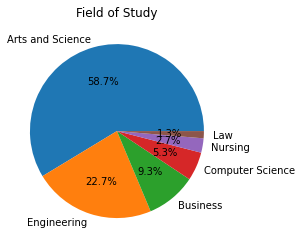

In [13]:
# replace majors with colleges
pp_data['field_of_study'] = pp_data['field_of_study'].replace('Psychology ', 'Arts and Science')
pp_data['field_of_study'] = pp_data['field_of_study'].replace('Pyschology', 'Arts and Science')
pp_data['field_of_study'] = pp_data['field_of_study'].replace('Chemistry', 'Arts and Science')
pp_data['field_of_study'] = pp_data['field_of_study'].replace('Computer Science ', 'Computer Science')
pp_data['field_of_study'] = pp_data['field_of_study'].replace('Legal (practicing attorney)', 'Law')
pp_data['field_of_study'] = pp_data['field_of_study'].replace('Nursing ', 'Nursing')
# make a pie chart out of field_of_study
field_of_study = pp_data['field_of_study'].value_counts()
# field_of_study.plot.pie(autopct='%1.1f%%')
plt.pie(field_of_study, labels=field_of_study.index, autopct='%1.1f%%')
plt.title('Field of Study')
plt.show()

### SQ2. Education Level

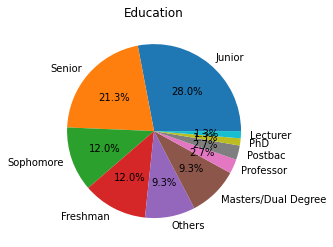

In [14]:
# post-bac
pp_data['education'] = pp_data['education'].replace('post baccalaureate', 'Postbac')
# other responses
pp_data['education'] = pp_data['education'].replace('Arts and Science', 'Others')
pp_data['education'] = pp_data['education'].replace('Graduated ', 'Others')
pp_data['education'] = pp_data['education'].replace('Exercise Science ', 'Others')
pp_data['education'] = pp_data['education'].replace('industry', 'Others')
pp_data['education'] = pp_data['education'].replace('I am a lawyer. I am not affiliated with the university. ', 'Others')
pp_data['education'] = pp_data['education'].replace('Research Engineering Technician', 'Others')
pp_data['education'] = pp_data['education'].replace('Alum', 'Others')
education_level = pp_data['education'].value_counts()
plt.pie(education_level, labels=education_level.index, autopct='%1.1f%%')
plt.title('Education')
plt.show()

### SQ3. Familiarity

In [15]:
# mean and median of familiarity
familiarity = pp_data['familiarity']
mean = familiarity.mean()
median = familiarity.median()
print(f'Familiarity Mean: {mean}')
print(f'Familiarity Median: {median}')

Familiarity Mean: 4.24
Familiarity Median: 5.0


### SQ4. Initial Trust

In [16]:
# mean and median of initial trust 
initial_trust = pp_data['initial_trust']
mean = initial_trust.mean()
median = initial_trust.median()
print(f'Initial trust mean: {mean}')
print(f'Initial trust median: {median}')

Initial trust mean: 4.8533333333333335
Initial trust median: 5.0


### SQ5. Experience with LLMs

## Future of LLMs
### SQ6. In what area do you think LLMs will be most used in the future?